## **Lane-Keeping with Hybrid Imitation and Reinforcement Learning (PPO)**

**Introduction:**
- Briefly describe the goal of the project.
- Overview of the methodology: CNN for feature extraction via imitation learning and PPO for reinforcement learning.

#### 1. Dependencies and Setup

- Import required libraries (TensorFlow/PyTorch, OpenAI Gym, Carla, NumPy, Matplotlib, etc.).
- Set up environment (GPU, paths, etc.).
- Any configuration settings (e.g., hyperparameters for PPO, CNN).

In [ ]:
# Import required libraries

#### 2. Dataset and Data Preprocessing

2.1. Data Collection:

- Describe how the training dataset is collected (e.g., camera images with corresponding steering angles).
- If using [Carla](https://carla.org/) Simulator, explain how the data is generated.

In [2]:
import os
# Create imgs folders if it doesn't exist
os.makedirs('imgs/semantic', exist_ok=True)
os.makedirs('imgs/rgb', exist_ok=True)

In [ ]:
'''
Print details for each datapoint.
    - WP Index
    - Yaw Adj
    - Steer Angle
    - Direction
    - Is Junction 
'''

import carla
import time
import numpy as np
import math
import sys
import random

sys.path.append('C:/CARLA_0.9.15/PythonAPI/carla')
from agents.navigation.global_route_planner import GlobalRoutePlanner

YAW_ADJ_DEGREES = 25  # Maximum yaw angle

def get_angle(car, wp):
    """Calculate angle between car and waypoint"""
    vehicle_pos = car.get_transform()
    car_x = vehicle_pos.location.x
    car_y = vehicle_pos.location.y
    wp_x = wp.transform.location.x
    wp_y = wp.transform.location.y
    
    distance = ((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    
    if distance == 0:
        x = 0
        y = 0
    else:
        x = (wp_x - car_x) / distance
        y = (wp_y - car_y) / distance
        
    car_vector = vehicle_pos.get_forward_vector()
    degrees = math.degrees(np.arctan2(y, x) - np.arctan2(car_vector.y, car_vector.x))
    
    # Normalize angle to [-180, 180]
    if degrees < -180:
        degrees = degrees + 360
    elif degrees > 180:
        degrees = degrees - 360
    
    return degrees

def get_distant_angle(car, wp_idx, rte, delta):
    """Get general direction at a distance ahead"""
    if wp_idx + delta < len(rte) - 1:
        i = wp_idx + delta
    else:
        i = len(rte) - 1
    
    # Check for intersection within the look forward
    intersection_detected = False
    for x in range(i - wp_idx):
        if rte[wp_idx + x][0].is_junction:
            intersection_detected = True
            intersection_ref = wp_idx + x
            break
    
    if not intersection_detected:
        result = 0
    else:
        angles_planned = []
        all_angles = []
        
        junction_wps = rte[intersection_ref][0].get_junction().get_waypoints(carla.LaneType.Driving)
        for wp in junction_wps:
            angle = int(get_angle(car, wp[1]))
            
            if wp[1].transform.location.distance(rte[intersection_ref][0].transform.location) > 20:
                for i in range(intersection_ref, len(rte) - 1):
                    if wp[1].transform.location.distance(rte[i][0].transform.location) < 10:
                        angles_planned.append(angle)
                    else:
                        all_angles.append(angle)
        
        angles_planned = list(set(angles_planned))
        all_angles = list(set(all_angles))
        alternative_angles = [item for item in all_angles if item not in angles_planned]
        
        if len(alternative_angles) == 0 or len(angles_planned) == 0:
            result = 0
        elif min(angles_planned) < -25 and (min(alternative_angles) > min(angles_planned)):
            result = -1  # Left turn
        elif max(angles_planned) > 25 and (max(alternative_angles) < max(angles_planned)):
            result = 1   # Right turn
        else:
            result = 0
    
    return result

def select_random_route(position, locs, world_map):
    """Select a random route with minimum distance"""
    point_a = position.location
    sampling_resolution = 1
    grp = GlobalRoutePlanner(world_map, sampling_resolution)
    
    min_distance = 100
    route_list = []
    
    for loc in locs:
        cur_route = grp.trace_route(point_a, loc.location)
        if len(cur_route) > min_distance:
            route_list.append(cur_route)
    
    if route_list:
        return random.choice(route_list)
    return None

def cleanup(world):
    """Destroy all actors"""
    for actor in world.get_actors().filter('*vehicle*'):
        actor.destroy()
    for actor in world.get_actors().filter('*sensor*'):
        actor.destroy()

def main():
    # Connect to CARLA
    client = carla.Client('localhost', 2000)
    client.set_timeout(10)
    world = client.get_world()
    
    # Configure world settings
    settings = world.get_settings()
    settings.synchronous_mode = False
    settings.no_rendering_mode = True
    world.apply_settings(settings)
    
    cleanup(world)
    spawn_points = world.get_map().get_spawn_points()
    
    # Test with one route
    start_point = random.choice(spawn_points)
    vehicle_bp = world.get_blueprint_library().filter('*model3*')
    vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
    
    if vehicle is None:
        print("Failed to spawn vehicle")
        return
    
    time.sleep(2)
    
    # Generate route
    route = select_random_route(start_point, spawn_points, world.get_map())
    
    if route is None:
        print("Failed to generate route")
        cleanup(world)
        return
    
    print(f"Route length: {len(route)} waypoints")
    print("=" * 80)
    print(f"{'WP Index':<10} {'Yaw Adj':<10} {'Steer Angle':<15} {'Direction':<12} {'Is Junction':<12}")
    print("=" * 80)
    
    gen_dir_angle = 0
    
    # Test more waypoints to find junctions
    test_waypoints = min(100, len(route) - 10)
    
    for idx in range(test_waypoints):
        waypoint = route[idx]
        transform = waypoint[0].transform
        vehicle.set_transform(transform)
        time.sleep(0.5)
        
        initial_yaw = waypoint[0].transform.rotation.yaw
        
        # Update general direction angle outside intersections
        if not waypoint[0].is_intersection and not waypoint[0].is_junction:
            gen_dir_angle = get_distant_angle(vehicle, idx, route, 30)
        
        # Check for lane change
        lane_change = False
        if not waypoint[0].is_intersection and not waypoint[0].is_junction:
            if idx < len(route) - 2:
                if route[idx][0].lane_id != route[idx + 1][0].lane_id:
                    lane_change = True
        
        if lane_change:
            if get_angle(vehicle, route[idx + 1][0]) < 0:
                gen_dir_angle = -1
            else:
                gen_dir_angle = 1
        
        # Test with 3 random yaw adjustments per waypoint
        for i in range(3):
            trans = waypoint[0].transform
            angle_adj = random.randrange(-YAW_ADJ_DEGREES, YAW_ADJ_DEGREES, 1)
            trans.rotation.yaw = initial_yaw + angle_adj
            vehicle.set_transform(trans)
            time.sleep(0.3)
            
            if idx + 5 < len(route) - 1:
                predicted_angle = get_angle(vehicle, route[idx + 5][0])
                
                # Determine direction label
                direction = gen_dir_angle  # -1, 0, or 1
                
                is_junction = "Yes" if waypoint[0].is_junction else "No"
                
                # Only print if something interesting (junction or direction change)
                if waypoint[0].is_junction or gen_dir_angle != 0 or abs(predicted_angle) > 30:
                    print(f"{idx:<10} {angle_adj:+4d}°{'':<5} {predicted_angle:+7.1f}°{'':<6} {direction:+2d}{'':<10} {is_junction:<12}")
    
    print("=" * 80)
    print("\nTest complete!")
    print("\nLegend:")
    print("  Direction: -1 = Left turn, 0 = Straight, +1 = Right turn")
    print("  Steer Angle: Angle to waypoint 5 steps ahead")
    print("  Yaw Adj: Random yaw adjustment applied to vehicle")
    
    cleanup(world)


try:
    main()
except KeyboardInterrupt:
    print("\nInterrupted by user")
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()


Interrupted by user


In [ ]:
'''
Visualize data features with realtime front cam footage to confirm its correction.
'''

import carla
import time
import numpy as np
import math
import sys
import random
import cv2

sys.path.append('C:/CARLA_0.9.15/PythonAPI/carla')
from agents.navigation.global_route_planner import GlobalRoutePlanner

YAW_ADJ_DEGREES = 25  # Maximum yaw angle

# Camera settings
CAMERA_POS_Z = 1.3
CAMERA_POS_X = 1.4
CAM_HEIGHT = 480
CAM_WIDTH = 640
FOV = 90

def camera_callback(image, data_dict):
    """Callback for RGB camera"""
    data_dict['image'] = np.reshape(np.copy(image.raw_data), (image.height, image.width, 4))[:, :, :3]

def get_angle(car, wp):
    """Calculate angle between car and waypoint"""
    vehicle_pos = car.get_transform()
    car_x = vehicle_pos.location.x
    car_y = vehicle_pos.location.y
    wp_x = wp.transform.location.x
    wp_y = wp.transform.location.y
    
    distance = ((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    
    if distance == 0:
        x = 0
        y = 0
    else:
        x = (wp_x - car_x) / distance
        y = (wp_y - car_y) / distance
        
    car_vector = vehicle_pos.get_forward_vector()
    degrees = math.degrees(np.arctan2(y, x) - np.arctan2(car_vector.y, car_vector.x))
    
    # Normalize angle to [-180, 180]
    if degrees < -180:
        degrees = degrees + 360
    elif degrees > 180:
        degrees = degrees - 360
    
    return degrees

def get_distant_angle(car, wp_idx, rte, delta):
    """Get general direction at a distance ahead"""
    if wp_idx + delta < len(rte) - 1:
        i = wp_idx + delta
    else:
        i = len(rte) - 1
    
    # Check for intersection within the look forward
    intersection_detected = False
    for x in range(i - wp_idx):
        if rte[wp_idx + x][0].is_junction:
            intersection_detected = True
            intersection_ref = wp_idx + x
            break
    
    if not intersection_detected:
        result = 0
    else:
        angles_planned = []
        all_angles = []
        
        junction_wps = rte[intersection_ref][0].get_junction().get_waypoints(carla.LaneType.Driving)
        for wp in junction_wps:
            angle = int(get_angle(car, wp[1]))
            
            if wp[1].transform.location.distance(rte[intersection_ref][0].transform.location) > 20:
                for i in range(intersection_ref, len(rte) - 1):
                    if wp[1].transform.location.distance(rte[i][0].transform.location) < 10:
                        angles_planned.append(angle)
                    else:
                        all_angles.append(angle)
        
        angles_planned = list(set(angles_planned))
        all_angles = list(set(all_angles))
        alternative_angles = [item for item in all_angles if item not in angles_planned]
        
        if len(alternative_angles) == 0 or len(angles_planned) == 0:
            result = 0
        elif min(angles_planned) < -25 and (min(alternative_angles) > min(angles_planned)):
            result = -1  # Left turn
        elif max(angles_planned) > 25 and (max(alternative_angles) < max(angles_planned)):
            result = 1   # Right turn
        else:
            result = 0
    
    return result

def select_random_route(position, locs, world_map):
    """Select a random route with minimum distance"""
    point_a = position.location
    sampling_resolution = 1
    grp = GlobalRoutePlanner(world_map, sampling_resolution)
    
    min_distance = 100
    route_list = []
    
    for loc in locs:
        cur_route = grp.trace_route(point_a, loc.location)
        if len(cur_route) > min_distance:
            route_list.append(cur_route)
    
    if route_list:
        return random.choice(route_list)
    return None

def cleanup(world):
    """Destroy all actors"""
    for actor in world.get_actors().filter('*vehicle*'):
        actor.destroy()
    for actor in world.get_actors().filter('*sensor*'):
        actor.destroy()

def draw_text_on_image(img, lines):
    """Draw multiple lines of text on image"""
    img_copy = img.copy()
    y_offset = 30
    for line in lines:
        cv2.putText(img_copy, line, (10, y_offset), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        y_offset += 30
    return img_copy

def main():
    # Connect to CARLA
    client = carla.Client('localhost', 2000)
    client.set_timeout(10)
    world = client.get_world()
    
    # Configure world settings
    settings = world.get_settings()
    settings.synchronous_mode = False
    settings.no_rendering_mode = False  # Enable rendering for camera
    world.apply_settings(settings)
    
    cleanup(world)
    spawn_points = world.get_map().get_spawn_points()
    
    # Spawn vehicle
    start_point = random.choice(spawn_points)
    vehicle_bp = world.get_blueprint_library().filter('*model3*')
    vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
    
    if vehicle is None:
        print("Failed to spawn vehicle")
        return
    
    time.sleep(2)
    
    # Setup RGB Camera
    camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
    camera_bp.set_attribute('image_size_x', str(CAM_WIDTH))
    camera_bp.set_attribute('image_size_y', str(CAM_HEIGHT))
    camera_bp.set_attribute('fov', str(FOV))
    camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z, x=CAMERA_POS_X))
    
    camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=vehicle)
    
    # Camera data dictionary
    camera_data = {'image': np.zeros((CAM_HEIGHT, CAM_WIDTH, 3))}
    camera.listen(lambda image: camera_callback(image, camera_data))
    
    # Wait for first image
    time.sleep(2)
    
    # Generate route
    route = select_random_route(start_point, spawn_points, world.get_map())
    
    if route is None:
        print("Failed to generate route")
        cleanup(world)
        return
    
    print(f"\nRoute generated with {len(route)} waypoints")
    print("=" * 80)
    print("Press 'n' in console to go to next waypoint, or Ctrl+C to quit")
    print("=" * 80)
    
    # Create OpenCV window
    cv2.namedWindow('RGB Camera with Info', cv2.WINDOW_AUTOSIZE)
    
    # Interactive loop
    while True:
        # Choose random waypoint (avoid last 10 waypoints)
        idx = random.randint(0, len(route) - 11)
        waypoint = route[idx]
        
        # Move vehicle to waypoint
        transform = waypoint[0].transform
        vehicle.set_transform(transform)
        time.sleep(1)
        
        initial_yaw = waypoint[0].transform.rotation.yaw
        
        # Calculate general direction angle
        gen_dir_angle = 0
        if not waypoint[0].is_intersection and not waypoint[0].is_junction:
            gen_dir_angle = get_distant_angle(vehicle, idx, route, 30)
        
        # Check for lane change
        lane_change = False
        if not waypoint[0].is_intersection and not waypoint[0].is_junction:
            if idx < len(route) - 2:
                if route[idx][0].lane_id != route[idx + 1][0].lane_id:
                    lane_change = True
        
        if lane_change:
            if get_angle(vehicle, route[idx + 1][0]) < 0:
                gen_dir_angle = -1
            else:
                gen_dir_angle = 1
        
        # Apply random yaw adjustment
        angle_adj = random.randrange(-YAW_ADJ_DEGREES, YAW_ADJ_DEGREES, 1)
        trans = waypoint[0].transform
        trans.rotation.yaw = initial_yaw + angle_adj
        vehicle.set_transform(trans)
        time.sleep(1)
        
        # Calculate steering angle
        predicted_angle = get_angle(vehicle, route[idx + 5][0])
        
        # Get waypoint info
        is_junction = "Yes" if waypoint[0].is_junction else "No"
        direction_label = {-1: "LEFT TURN", 0: "STRAIGHT", 1: "RIGHT TURN"}[gen_dir_angle]
        
        # Print to console
        print(f"\n--- Waypoint {idx} / {len(route)} ---")
        print(f"Initial Yaw:     {initial_yaw:.1f}°")
        print(f"Yaw Adjustment:  {angle_adj:+d}°")
        print(f"Final Yaw:       {initial_yaw + angle_adj:.1f}°")
        print(f"Steering Angle:  {predicted_angle:+.1f}°")
        print(f"Direction:       {gen_dir_angle:+d} ({direction_label})")
        print(f"Is Junction:     {is_junction}")
        print(f"Lane Change:     {'Yes' if lane_change else 'No'}")
        
        # Display image with text overlay
        while True:
            if np.sum(camera_data['image']) > 0:
                # Prepare text lines
                text_lines = [
                    f"Waypoint: {idx}/{len(route)}",
                    f"Initial Yaw: {initial_yaw:.1f}",
                    f"Yaw Adj: {angle_adj:+d}",
                    f"Steer Angle: {predicted_angle:+.1f}",
                    f"Direction: {gen_dir_angle} ({direction_label})",
                    f"Junction: {is_junction}",
                    f"Lane Change: {'Yes' if lane_change else 'No'}",
                    "",
                    "Press 'n' for next waypoint"
                ]
                
                # Draw text on image
                display_img = draw_text_on_image(camera_data['image'], text_lines)
                cv2.imshow('RGB Camera with Info', display_img)
                
                # Wait for key press
                key = cv2.waitKey(100)
                if key == ord('n') or key == ord('N'):
                    break
            else:
                time.sleep(0.1)
    
    cv2.destroyAllWindows()
    cleanup(world)


try:
    main()
except KeyboardInterrupt:
    print("\n\nInterrupted by user")
    cv2.destroyAllWindows()
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
    cv2.destroyAllWindows()


Route generated with 402 waypoints
Press 'n' in console to go to next waypoint, or Ctrl+C to quit

--- Waypoint 73 / 402 ---
Initial Yaw:     -90.2°
Yaw Adjustment:  +6°
Final Yaw:       -84.2°
Steering Angle:  -6.0°
Direction:       +0 (STRAIGHT)
Is Junction:     No
Lane Change:     No

--- Waypoint 98 / 402 ---
Initial Yaw:     -90.2°
Yaw Adjustment:  +24°
Final Yaw:       -66.2°
Steering Angle:  -24.0°
Direction:       +0 (STRAIGHT)
Is Junction:     Yes
Lane Change:     No

--- Waypoint 286 / 402 ---
Initial Yaw:     360.0°
Yaw Adjustment:  -11°
Final Yaw:       349.0°
Steering Angle:  +11.0°
Direction:       +0 (STRAIGHT)
Is Junction:     No
Lane Change:     No

--- Waypoint 268 / 402 ---
Initial Yaw:     0.6°
Yaw Adjustment:  +1°
Final Yaw:       1.6°
Steering Angle:  -1.0°
Direction:       +0 (STRAIGHT)
Is Junction:     No
Lane Change:     No

--- Waypoint 230 / 402 ---
Initial Yaw:     -63.2°
Yaw Adjustment:  -12°
Final Yaw:       -75.2°
Steering Angle:  +20.2°
Direction:      

In [1]:
''' 
Generate Data

Image generation rate ~ 2500/Hr
Space per semantic image ~ 35KB
Space per rgb image ~ 440KB

'''

import carla
import time
import cv2
import numpy as np
import math
import sys
import random
sys.path.append('C:/CARLA_0.9.15/PythonAPI/carla') # Carla Path !!
from agents.navigation.global_route_planner import GlobalRoutePlanner

SHOW_RGB = False # To display cam footage on a window (Turned off for better performance)

# Cam position relative to the vehicle
CAMERA_POS_Z = 1.3
CAMERA_POS_X = 1.4

# Image size
CAM_HEIGHT = 480
CAM_WIDTH = 640

FOV = 90

YAW_ADJ_DEGREES = 25 # Maximum yaw angle

def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))[:, :, :3]

def sem_callback(image,data_dict):
    #change for Semantic camera
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))[:, :, :3]

def cleanup(): # Destroy all the actors in the simulation
    for actor in world.get_actors().filter('*vehicle*'):
        actor.destroy()
    for actor in world.get_actors().filter('*sensor*'):
        actor.destroy()


# Angle between the car and waypoint
def get_angle(car,wp):
    vehicle_pos = car.get_transform()
    car_x = vehicle_pos.location.x
    car_y = vehicle_pos.location.y
    wp_x = wp.transform.location.x
    wp_y = wp.transform.location.y
    
    if ((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5 == 0:
        x=0
        y=0
    else:
        x = (wp_x - car_x)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
        y = (wp_y - car_y)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
        
    car_vector = vehicle_pos.get_forward_vector()
    degrees = math.degrees(np.arctan2(y, x) - np.arctan2(car_vector.y, car_vector.x))
    # extra checks on predicted angle when values close to 360 degrees are returned
    if degrees<-180:
        degrees = degrees + 360
    elif degrees > 180:
        degrees = degrees - 360
    return degrees

# get angle to a waypoint at a distance
def get_distant_angle(car,wp_idx,rte, delta):
    if wp_idx + delta < len(rte)-1:
        i = wp_idx + delta
    else:
        i = len(rte)-1
    # check for intersection within the look forward
    # so we do not give turn results when just following the road
    intersection_detected = False
    for x in range(i-wp_idx):
        if rte[wp_idx+x][0].is_junction:
             intersection_detected = True
             intersection_ref = wp_idx+x
             break
    if not intersection_detected:
        result = 0
    else: # check out the intersection
        angles_planned = [] # list of angles towards current exit from the intersection
        all_angles = []
        
        junction_wps = rte[intersection_ref][0].get_junction().get_waypoints(carla.LaneType.Driving)
        for wp in junction_wps:
            angle = int(get_angle(car,wp[1])) 

            if wp[1].transform.location.distance(route[intersection_ref][0].transform.location) > 20: 
  
                for i in range(intersection_ref,len(route)-1):
                    if wp[1].transform.location.distance(route[i][0].transform.location) < 10:
                        angles_planned.append(angle)
                    else:
                        all_angles.append(angle)
        angles_planned = list(set(angles_planned))
        all_angles = list(set(all_angles))
        alternative_angles = [item for item in all_angles if item not in angles_planned] 
        if len(alternative_angles) == 0 or len(angles_planned) == 0:
            result = 0
        elif min(angles_planned)<-25 and (min(alternative_angles) > min(angles_planned)):
            #we are planning left turn
            result = -1
        elif max(angles_planned)>25 and (max(alternative_angles) < max(angles_planned)):
            result = 1
        else:
            result = 0  
    return result


def select_random_route(position,locs):
    point_a = position.location #start at where the car is or last waypoint
    sampling_resolution = 1
    grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
    # pick the longest possible route
    min_distance = 100
    result_route = None
    route_list = []
    for loc in locs: 
        cur_route = grp.trace_route(point_a, loc.location)
        if len(cur_route) > min_distance:
            route_list.append(cur_route)
    result_route = random.choice(route_list)
    return result_route

def main():
    client = carla.Client('localhost', 2000)
    time.sleep(5) # just in case
    client.set_timeout(10) # increase if failed to connect in time or check for port 2000 
    world = client.get_world()
    settings = world.get_settings()
    settings.synchronous_mode = False
    settings.no_rendering_mode = True
    if settings.synchronous_mode:
        settings.fixed_delta_seconds = 0.05
    world.apply_settings(settings)

    cleanup()
    spawn_points = world.get_map().get_spawn_points()

    while True:
        start_point = random.choice(spawn_points)
        vehicle_bp = world.get_blueprint_library().filter('*model3*')
        vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
        time.sleep(2)
    
        # RGB CAM
        camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
        camera_bp.set_attribute('image_size_x', str(CAM_WIDTH))
        camera_bp.set_attribute('image_size_y', str(CAM_HEIGHT))
        camera_bp.set_attribute('fov', str(FOV))
        camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))

        camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)
        image_w = camera_bp.get_attribute('image_size_x').as_int()
        image_h = camera_bp.get_attribute('image_size_y').as_int()
        camera_data = {'image': np.zeros((image_h,image_w,3)),
                    'sem_image': np.zeros((image_h,image_w,3))}
        
        camera.listen(lambda image: camera_callback(image,camera_data))

        # Semantic cam
        sem_camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
        sem_camera_bp.set_attribute('image_size_x', str(CAM_WIDTH))
        sem_camera_bp.set_attribute('image_size_y', str(CAM_HEIGHT))
        sem_camera_bp.set_attribute('fov', str(FOV))
    
        sem_camera = world.spawn_actor(sem_camera_bp,camera_init_trans,attach_to=vehicle)
        
        sem_camera.listen(lambda image: sem_callback(image,camera_data))

        if SHOW_RGB:
            cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
            cv2.imshow('RGB Camera',camera_data['image'])
        
        route = select_random_route(start_point,spawn_points)
        gen_dir_angle = 0 # in case we did not get a general GPS direction
        for idx, waypoint in enumerate(route): # move the car through the route (Not real navigation !!!)
            
            transform = waypoint[0].transform
            vehicle.set_transform(transform)
            vehicle.apply_control(carla.VehicleControl(throttle=0, steer=0, brake=1))
            time.sleep(2)
            initial_yaw = waypoint[0].transform.rotation.yaw
            # GPS general direction is only taken outside intersections
            if not waypoint[0].is_intersection and not waypoint[0].is_junction:
                gen_dir_angle = get_distant_angle(vehicle,idx,route,30) # general angle taken before spinning the car
            # logic to detect a lane change and ignore/not take those images
            lane_change = False
            if not waypoint[0].is_intersection and not waypoint[0].is_junction:
                if idx < len(route)-2:
                    if route[idx][0].lane_id != route[idx+1][0].lane_id:
                        lane_change = True
            if lane_change: # lane changes are treated as turns in general direction
                if get_angle(vehicle,route[idx+1][0])<0:
                    gen_dir_angle = -1
                else:
                    gen_dir_angle = 1

            for i in range(5):
                trans = waypoint[0].transform
                angle_adj = random.randrange(-YAW_ADJ_DEGREES, YAW_ADJ_DEGREES, 1)
                trans.rotation.yaw = initial_yaw +angle_adj 
                vehicle.set_transform(trans)
                vehicle.apply_control(carla.VehicleControl(throttle=0, steer=0, brake=1))
                time.sleep(1) 
                
                
                if SHOW_RGB:
                    cv2.imshow('RGB Camera',camera_data['image'])
                
                if idx +5 < len(route)-1: # Check for end of the route
                    predicted_angle = get_angle(vehicle,route[idx+5][0]) # we always get the angle to +5 waypoint ahead of us
                    
                    time_grab = time.time_ns()
                    rgb_image = camera_data['image']
                    sem_image = camera_data['sem_image']
                    if np.sum(sem_image) > 0: #check for black images (This not work if image has at least one rgb value)
                        # So make sure to check the dataset before train the model
                        cv2.imwrite('imgs/semantic/%019d_%s_%s.png' % (time_grab, gen_dir_angle, round(predicted_angle,0)), sem_image)
                        cv2.imwrite('imgs/rgb/%019d_%s_%s.png' % (time_grab, gen_dir_angle, round(predicted_angle,0)), rgb_image)
    cleanup()
    cv2.destroyAllWindows()


try:
    main()
except KeyboardInterrupt:
    print("\n\nInterrupted by user")
    cv2.destroyAllWindows()
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
    cv2.destroyAllWindows()



Interrupted by user


2.2. Data Preprocessing:

- Segmentation of camera images (any transformations, resizing)
- Normalization of steering angles
- Visualizations of segmented images to show what the model will see

DIRECTION LABEL DISTRIBUTION
Total Images: 80280

Direction -1 (LEFT TURN  ):  14315 images ( 17.8%)
Direction +0 (STRAIGHT   ):  54900 images ( 68.4%)
Direction +1 (RIGHT TURN ):  11065 images ( 13.8%)

Plot saved as 'direction_analysis.png'


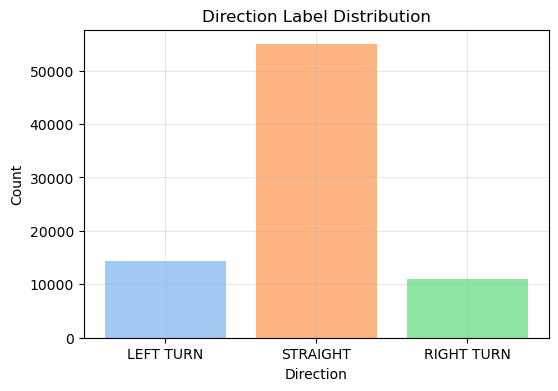

In [18]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set Seaborn style to pastel
colors = sns.color_palette("pastel")

# Path to your images
img_path = 'imgs/semantic'  # or 'imgs/rgb'

# Get all filenames
files = os.listdir(img_path)

# Extract direction labels from filenames
directions = []
for f in files:
    if f.endswith('.png'):
        parts = f.split('_')
        if len(parts) >= 2:
            direction = int(parts[1])  # Direction is second part
            directions.append(direction)

# Count each direction
direction_counts = Counter(directions)

# Print results
print("="*50)
print("DIRECTION LABEL DISTRIBUTION")
print("="*50)
total = len(directions)
print(f"Total Images: {total}\n")

for direction in sorted(direction_counts.keys()):
    count = direction_counts[direction]
    percentage = (count / total) * 100
    label_name = {-1: "LEFT TURN", 0: "STRAIGHT", 1: "RIGHT TURN"}[direction]
    print(f"Direction {direction:+2d} ({label_name:11s}): {count:6d} images ({percentage:5.1f}%)")

print("="*50)

# Create a plot
direction_labels = {-1: "LEFT TURN", 0: "STRAIGHT", 1: "RIGHT TURN"}
labels = [direction_labels[d] for d in sorted(direction_counts.keys())]
counts = [direction_counts[d] for d in sorted(direction_counts.keys())]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=colors)
plt.xlabel('Direction')
plt.ylabel('Count')
plt.title('Direction Label Distribution')
plt.grid(True, alpha=0.3)

plt.savefig('analysis_plots/direction_analysis.png', dpi=150)
print("\nPlot saved as 'direction_analysis.png'")
plt.show()


STEERING ANGLE STATISTICS
Total Images: 80280
Min Steering:    -66.0°
Max Steering:    +68.0°
Mean Steering:    +1.4°
Std Dev:          15.3°

Plot saved as 'steering_analysis.png'


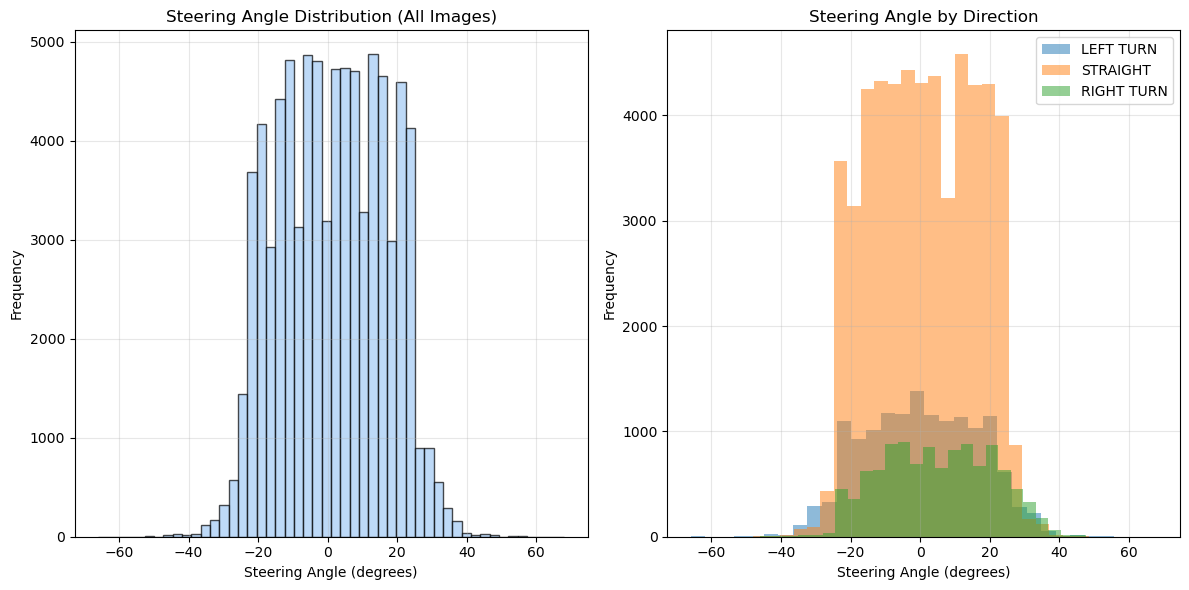

In [17]:
steering_angles = []
directions = []

for f in files:
    if f.endswith('.png'):
        parts = f.split('_')
        if len(parts) >= 3:
            direction = int(parts[1])
            steering = float(parts[2].replace('.png', ''))
            directions.append(direction)
            steering_angles.append(steering)

# Convert to numpy arrays
steering_angles = np.array(steering_angles)
directions = np.array(directions)

print("="*50)
print("STEERING ANGLE STATISTICS")
print("="*50)
print(f"Total Images: {len(steering_angles)}")
print(f"Min Steering:  {steering_angles.min():+7.1f}°")
print(f"Max Steering:  {steering_angles.max():+7.1f}°")
print(f"Mean Steering: {steering_angles.mean():+7.1f}°")
print(f"Std Dev:       {steering_angles.std():7.1f}°")
print("="*50)

# Plot histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(steering_angles, bins=50, edgecolor='black', alpha=0.7, color=colors[0])
plt.xlabel('Steering Angle (degrees)')
plt.ylabel('Frequency')
plt.title('Steering Angle Distribution (All Images)')
plt.grid(True, alpha=0.3)

# Plot by direction
plt.subplot(1, 2, 2)
for direction in [-1, 0, 1]:
    mask = directions == direction
    label_name = direction_labels[direction]
    plt.hist(steering_angles[mask], bins=30, alpha=0.5, label=label_name)

plt.xlabel('Steering Angle (degrees)')
plt.ylabel('Frequency')
plt.title('Steering Angle by Direction')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analysis_plots/steering_analysis.png', dpi=150)
print("\nPlot saved as 'steering_analysis.png'")
plt.show()

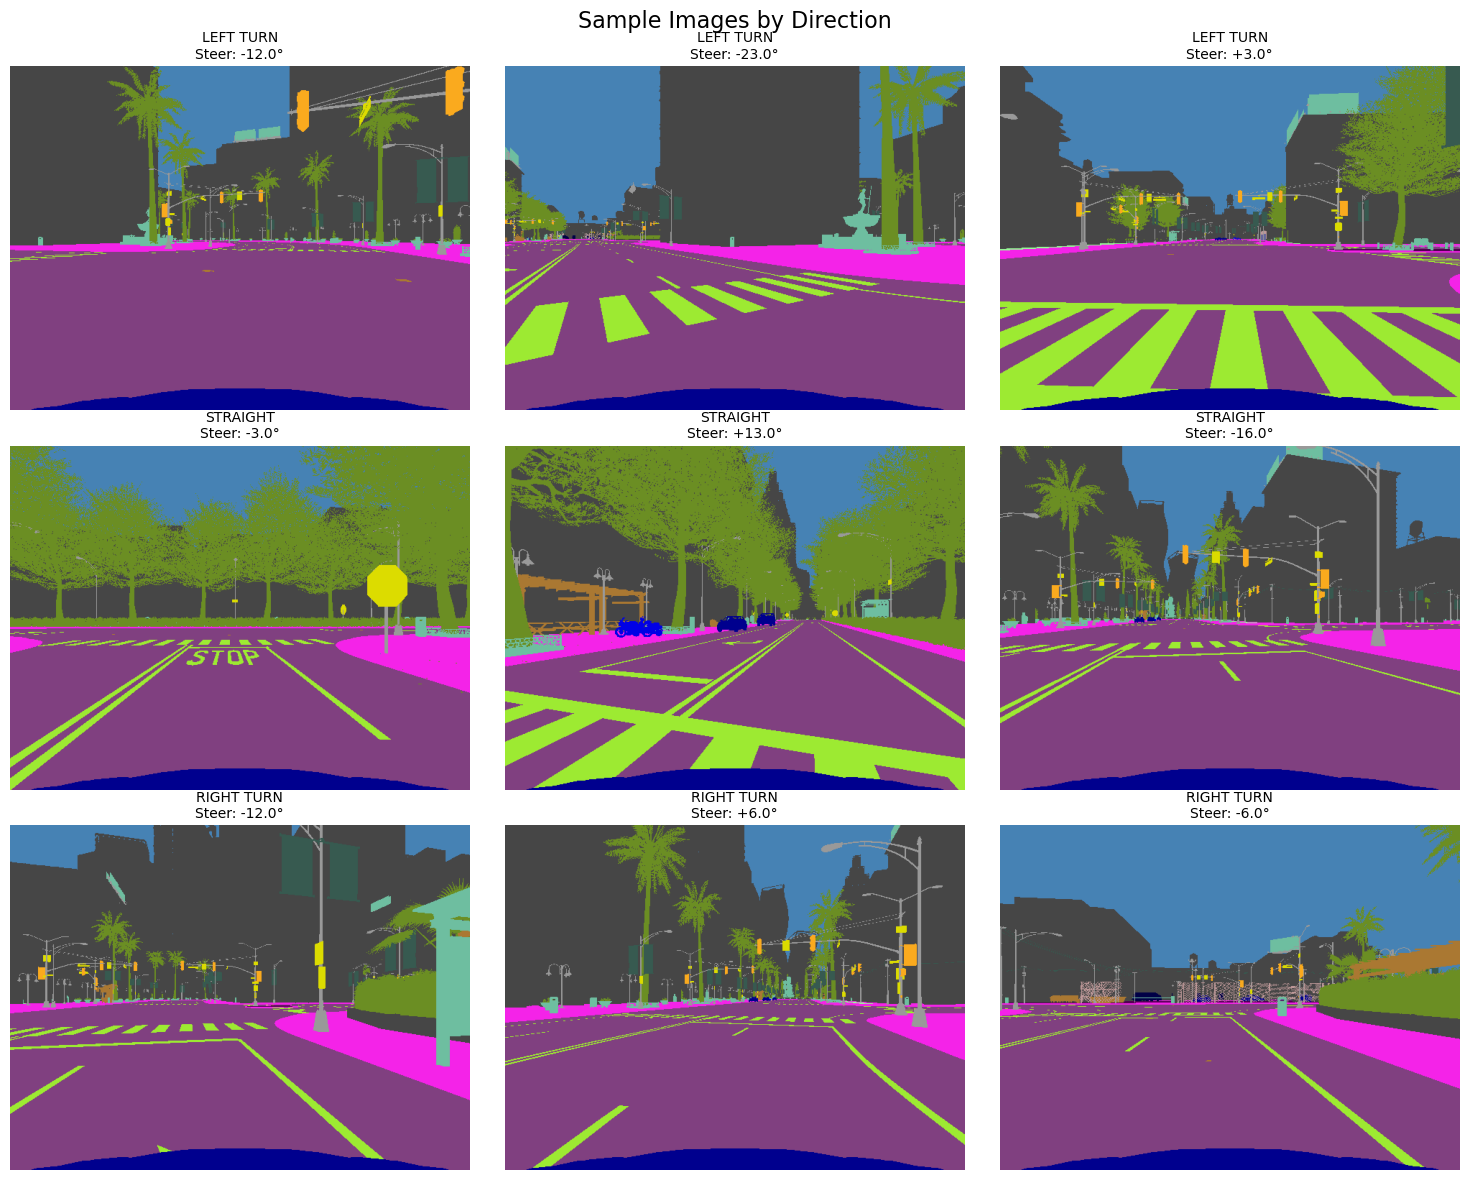

In [ ]:
files_by_direction = {-1: [], 0: [], 1: []}

for f in files:
    parts = f.split('_')
    if len(parts) >= 2:
        direction = int(parts[1])
        files_by_direction[direction].append(f)

# Display samples
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Sample Images by Direction', fontsize=16)

for idx, direction in enumerate([-1, 0, 1]):
    label_name = direction_labels[direction]
    
    if len(files_by_direction[direction]) == 0:
        for col in range(3):
            axes[idx, col].text(0.5, 0.5, 'NO DATA', 
                               ha='center', va='center', fontsize=20, color='red')
            axes[idx, col].axis('off')
        continue
    
    # Pick 3 random samples
    samples = random.sample(files_by_direction[direction], 
                           min(3, len(files_by_direction[direction])))

    for col, sample_file in enumerate(samples):
        img = cv2.imread(os.path.join(img_path, sample_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Extract steering angle from filename
        steering = float(sample_file.split('_')[2].replace('.png', ''))
        
        axes[idx, col].imshow(img)
        axes[idx, col].set_title(f'{label_name}\nSteer: {steering:+.1f}°', fontsize=10)
        axes[idx, col].axis('off')

plt.tight_layout()
plt.savefig('analysis_plots/sample_images.png', dpi=150, bbox_inches='tight')
print("Sample images saved as 'sample_images.png'")
plt.show()

#### 3. Stage 1: Imitation Learning with CNN

3.1. Model Architecture:
- Define and explain the CNN architecture.
- Example: Convolutional layers, pooling, fully connected layers, output layer (steering angle).

In [6]:
# code

3.2. Training the CNN:
- Loss function (e.g., Mean Squared Error).
- Optimizer (e.g., Adam).
- Training loop and evaluation.
- Visualize loss curve and predictions vs. ground truth.

In [7]:
# code

3.3. Feature Extraction:
- Remove the last layer of the CNN and show how the feature vector is extracted.
- Example: Demonstrate the dimensionality of the feature vector.

In [8]:
# code

#### 4. Stage 2: Integration with PPO

4.1. PPO Setup:
- Define PPO architecture for the lane-keeping task.
- Explain how the feature vector from the CNN is used as the input to PPO’s observation space.

In [9]:
'''
this is an RL environment for step-by-step Tutorial
'''

'\nthis is an RL environment for step-by-step Tutorial\n'

4.2. Action and Reward Setup:
- Actions (steering angle or continuous control for steering, throttle, brake).
- Reward function (e.g., staying in the center of the lane, penalty for lane departure).

4.3. Training PPO:
- PPO training loop (number of episodes, time steps).
- Visualize training progress (e.g., reward over time, lane-keeping performance).

In [5]:
#code

#### 5. Evaluation and Results

5.1. Evaluation Setup:
- Test the agent in different lane-keeping scenarios (e.g., straight roads, curves, and obstacles).
- Visualize the agent’s lane-keeping behavior using real-time plots.

5.2. Metrics:
- Lane center distance, steering smoothness.
- Visualizations: A side-by-side comparison of the agent’s trajectory versus ideal lane center.

5.3. Discussion:
- Compare results with baseline (if any) or human-driven performance.

In [6]:
#code

#### 6. Conclusion

- Summarize the key takeaways from the project.
- Reflect on the challenges, the success of combining imitation learning with PPO, and possible improvements (e.g., better reward design, adding more sensors, fine-tuning CNN during RL).

#### 7. Future Work and Improvements

- Discuss ideas for improving the system or extending it to more complex driving tasks (e.g., adding obstacle avoidance, handling diverse weather conditions).
- Suggest how the model could be generalized to different types of vehicles or environments (e.g., real-world data, simulations).

<h3 style="color:red; font-style:italic;">Final Checklist:</h3>

- *Comments & Markdown: Thorough explanations for each code block.*
- *Visualizations: Graphs (loss curves, steering predictions), lane visualizations, etc.*
- *Modularity: Keep each section modular so that it’s easy to follow, run, and modify.*
- *Documentation: Each code section should have accompanying comments to explain what’s being done.*